In [1]:
#basics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Data prep
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler

#model prep
from sklearn.model_selection import ParameterGrid

#models
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

#scoring 
from sklearn.metrics import silhouette_score

#exploration
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
#import data
originalData = pd.read_excel("Credit Card Customer Data.xlsx")
originalData.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


SI looks like an identity column that can be dropped. 

Customer Key could also be an identity column that might be dropped.

The data will need scaled The Avg_Credit_Limit column will dominate the other 4 columns in distance calculations. 

Outliers may also be present in the Avg_Credit_limit column.

In [3]:
originalData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


All columns are int64. No columns of type object so no text data present.

660 customers, with 7 explanatory variables.

In [4]:
# Check for missing value
originalData.isna().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

No missing data in any column. A nice clean dataset.

What about duplicates?

In [5]:
duplicateRows = originalData[originalData.duplicated()]
duplicateRows

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made


No duplicated customers to worry about. 

How skewed is the data?

In [6]:
originalData.skew()

Sl_No                  0.000000
Customer Key           0.051462
Avg_Credit_Limit       2.202396
Total_Credit_Cards     0.144879
Total_visits_bank      0.141896
Total_visits_online    2.225607
Total_calls_made       0.658905
dtype: float64

The columns "Avg_Credit_Limit" and "Total_visits_online" are significantly skewed and will need investigation for outliers and scaling

# Univariate Analysis

Explore each variable.

In [7]:
originalData.describe()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000
mean,330.500000,55141.443939,34574.242424,4.706061,2.403030,2.606061,3.583333
std,190.669872,25627.772200,37625.487804,2.167835,1.631813,2.935724,2.865317
min,1.000000,11265.000000,3000.000000,1.000000,0.000000,0.000000,0.000000
25%,165.750000,33825.250000,10000.000000,3.000000,1.000000,1.000000,1.000000
50%,330.500000,53874.500000,18000.000000,5.000000,2.000000,2.000000,3.000000
75%,495.250000,77202.500000,48000.000000,6.000000,4.000000,4.000000,5.000000
max,660.000000,99843.000000,200000.000000,10.000000,5.000000,15.000000,10.000000


The means and standard deviation are not consistent across all variables. The dataset will need to be standardised.

The significance of indvidual values will be discussed under each column heading.


### Sl_No

In [8]:
originalData["Sl_No"].nunique()

660

This is an identity column. It can be removed before the final analysis.

### Customer Key

In [9]:
display(["number of unique customers", originalData["Sl_No"].count()])

display(["number of unique Customer Keys", originalData["Customer Key"].nunique()])

['number of unique customers', 660]

['number of unique Customer Keys', 655]

We have 660 customers but only 655 uniqure customer keys. This needs explored and explained.

In [10]:
display(["number of unique customers", originalData["Customer Key"].count()])

display(["number of unique customer keys", originalData["Customer Key"].nunique()])

['number of unique customers', 660]

['number of unique customer keys', 655]

In [11]:
grouped = originalData.groupby("Customer Key")
grouped=grouped.filter(lambda x: len(x) > 1)
grouped = grouped.sort_values(by="Customer Key")
display(grouped)
grouped["Customer Key"].unique()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
48,49,37252,6000,4,0,2,8
432,433,37252,59000,6,2,1,2
4,5,47437,100000,6,0,12,3
332,333,47437,17000,7,3,1,0
411,412,50706,44000,4,5,0,2
541,542,50706,60000,7,5,2,2
391,392,96929,13000,4,5,0,0
398,399,96929,67000,6,2,2,2
104,105,97935,17000,2,1,2,10
632,633,97935,187000,7,1,7,0


array([37252, 47437, 50706, 96929, 97935], dtype=int64)

If the Customer Key , defines a single physical customer, it appear that 5 of the physical customers have 2 entries each in the data set. These entries are not duplicated data. It appears that one physical customer can be running with different credit limits and credit card amounts. 

As these customers account for 10 rows out of 660 we will not recommend any corrective action unless it turns out that these customers are outliers affecting results. Customer with Sl_No 633 and Customer Key 97935 is of concern. He has an average credit limit of 187,000 which is double the others.

### Avg_Credit _Limit

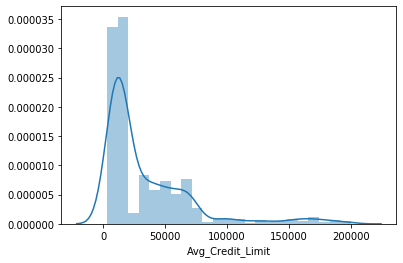

In [12]:
sns.distplot(originalData["Avg_Credit_Limit"])

In [13]:
originalData["Avg_Credit_Limit"].describe()

count       660.000000
mean      34574.242424
std       37625.487804
min        3000.000000
25%       10000.000000
50%       18000.000000
75%       48000.000000
max      200000.000000
Name: Avg_Credit_Limit, dtype: float64

The data is highly skewed. 75% of customers have less than 48K credit limits. Of the remianing 25% many have credit limits that are double this amount

We may be looking at 2 to 4 clusters. Expected grouping could end up being characterised as "low credit limits", "medium credit limits", "high credit limits" and "Very High Limits".

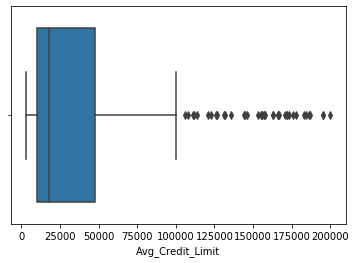

In [14]:
sns.boxplot(originalData["Avg_Credit_Limit"])

This confirms a significant number of outliers. The data will need to be log scaled and standarized before analysis.

## Total Credit Cards

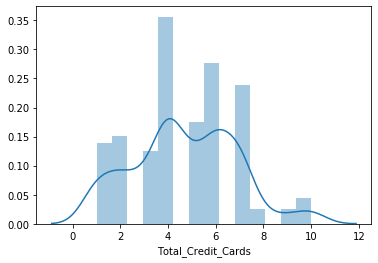

In [15]:
sns.distplot(originalData["Total_Credit_Cards"])

In [16]:
originalData["Total_Credit_Cards"].describe()

count    660.000000
mean       4.706061
std        2.167835
min        1.000000
25%        3.000000
50%        5.000000
75%        6.000000
max       10.000000
Name: Total_Credit_Cards, dtype: float64

This columns data looks blissfully easy to deal with a looks some what normally distributed.

## Total_visits_bank

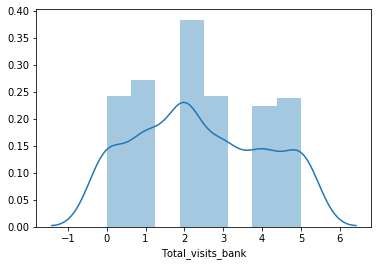

In [17]:
sns.distplot(originalData["Total_visits_bank"])

In [18]:
originalData["Total_visits_bank"].describe()

count    660.000000
mean       2.403030
std        1.631813
min        0.000000
25%        1.000000
50%        2.000000
75%        4.000000
max        5.000000
Name: Total_visits_bank, dtype: float64

This columns data looks easy to deal with and looks some what normally distributed.

## Total_visits_online

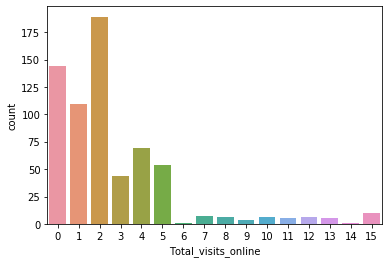

In [19]:
sns.countplot(originalData["Total_visits_online"])

In [20]:
originalData["Total_visits_bank"].describe()

count    660.000000
mean       2.403030
std        1.631813
min        0.000000
25%        1.000000
50%        2.000000
75%        4.000000
max        5.000000
Name: Total_visits_bank, dtype: float64

This column is highly skewed. It does suggest 3 clusters will be needed. 

Customer who do not use online facilities (zero visits), ocassional visitors (1-5 visits) and frequent users(6 or more vists)

This data set is skewed and will need to be scaled.

## Total_calls_made

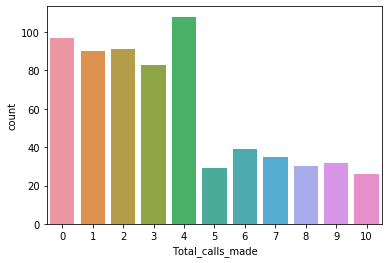

In [21]:
sns.countplot(originalData["Total_calls_made"])

In [22]:
originalData["Total_calls_made"].describe()

count    660.000000
mean       3.583333
std        2.865317
min        0.000000
25%        1.000000
50%        3.000000
75%        5.000000
max       10.000000
Name: Total_calls_made, dtype: float64

The mode is 4. The majority of customers have been contact 5 or fewer times.

This graph suggest 3 possible clusters may exist, those who haven't made calls(zero calls), those with a low number of calls (less than 5), those with frequent calls (5 or more).

# Multi-variate Analysis

In [23]:
#remove identit columns
originalData.drop(["Sl_No","Customer Key"],axis=1, inplace=True)

## Correlation

In [24]:
originalData.corr()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Avg_Credit_Limit,1.000000,0.608860,-0.100312,0.551385,-0.414352
Total_Credit_Cards,0.608860,1.000000,0.315796,0.167758,-0.651251
Total_visits_bank,-0.100312,0.315796,1.000000,-0.551861,-0.506016
Total_visits_online,0.551385,0.167758,-0.551861,1.000000,0.127299
Total_calls_made,-0.414352,-0.651251,-0.506016,0.127299,1.000000


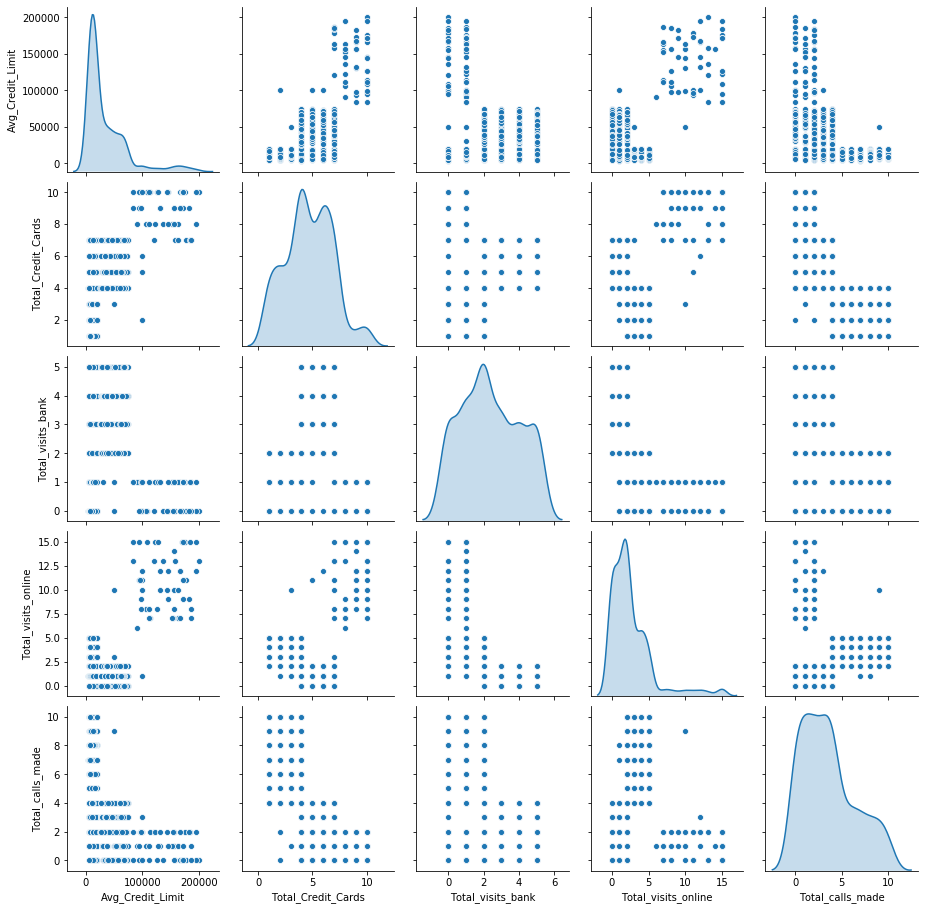

In [25]:
sns.pairplot(originalData,diag_kind='kde')

The correlatons and the pair plots suggest strong relationships between:

* Credit Limits and Credit Cards
* Credit Limits and online visits
* Total Credit Cards and Calls Made
* Total bank visits and online visits
* Total bank visits and calls made

### Bi-variate analysis

Based upon the above correlations we will investigate if clusters are occurring in the five pairings just mentioned.

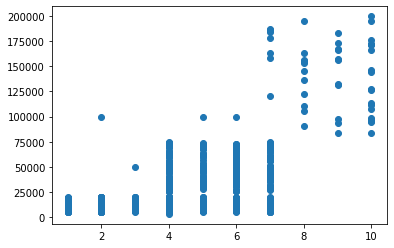

In [26]:
plt.scatter(originalData["Total_Credit_Cards"], originalData["Avg_Credit_Limit"])

This plot suggest 3 clusters. Thise with less than 4 credit credit cards and low limits. Those with less than 7 credit cards and low to medium limites and those with 8 or more credit cards with high limits.

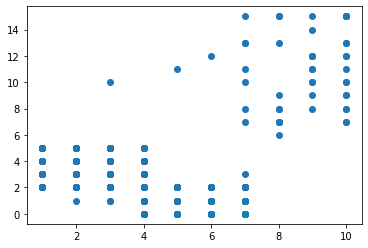

In [27]:
plt.scatter(originalData["Total_Credit_Cards"], originalData["Total_visits_online"])

This plot suggest 2 clusters. One in the bottom left to middle and one in the top right with.

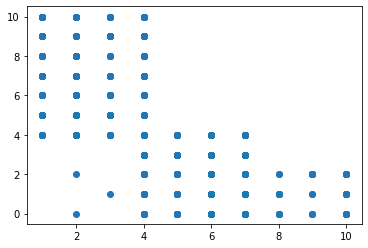

In [28]:
plt.scatter(originalData["Total_Credit_Cards"], originalData["Total_calls_made"])

This plot suggest 3 possible clusters. A cluster at the top left, a cluster in the middle bottom, a cluster at the right bottom.

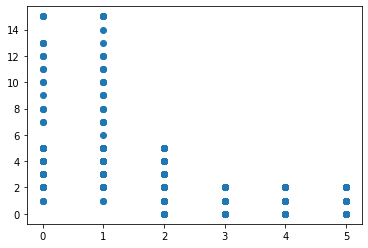

In [29]:
plt.scatter(originalData["Total_visits_bank"], originalData["Total_visits_online"])

This graph suggests 2 clusters. One on the left with values below 2 that stretch the full height of the graph. And one above 2 that is close to the bottom

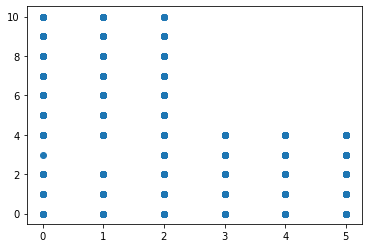

In [30]:
plt.scatter(originalData["Total_visits_bank"], originalData["Total_calls_made"])

This graph suggests 2 main clusters, one on the left below the value 3 and one on the right with values of 3 or greater.

### Expectation 

The final clustering is likely to be between 2 to 4 clusteris

# Transform Data

In [31]:
# log scale the credit limit
originalData = pd.read_excel("Credit Card Customer Data.xlsx")

#remove identit columns
originalData.drop(["Sl_No","Customer Key"],axis=1, inplace=True)
# log scale credit limit
originalData["Avg_Credit_Limit"] = np.log(originalData["Avg_Credit_Limit"])  
originalData

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,11.512925,2,1,1,0
1,10.819778,3,0,10,9
2,10.819778,7,1,3,4
3,10.308953,5,1,1,4
4,11.512925,6,0,12,3
...,...,...,...,...,...
655,11.502875,10,1,10,0
656,11.338572,10,1,13,2
657,11.884489,8,1,9,1
658,12.055250,10,1,15,0


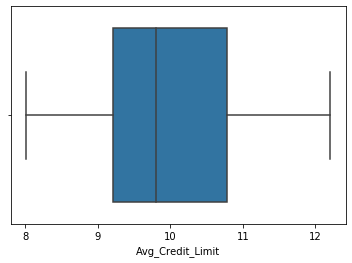

In [32]:
sns.boxplot(originalData["Avg_Credit_Limit"])

Log scaling has resulted in no outliers on the credit limit any more.

Apply Normalisation to all columns

In [33]:
scaler = StandardScaler()
transformedData = pd.DataFrame(scaler.fit_transform(originalData), columns=originalData.columns)
transformedData

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.630478,-1.249225,-0.860451,-0.547490,-1.251537
1,0.885387,-0.787585,-1.473731,2.520519,1.891859
2,0.885387,1.058973,-0.860451,0.134290,0.145528
3,0.336281,0.135694,-0.860451,-0.547490,0.145528
4,1.630478,0.597334,-1.473731,3.202298,-0.203739
...,...,...,...,...,...
655,1.619674,2.443892,-0.860451,2.520519,-1.251537
656,1.443058,2.443892,-0.860451,3.543188,-0.553005
657,2.029885,1.520613,-0.860451,2.179629,-0.902271
658,2.213443,2.443892,-0.860451,4.224968,-1.251537


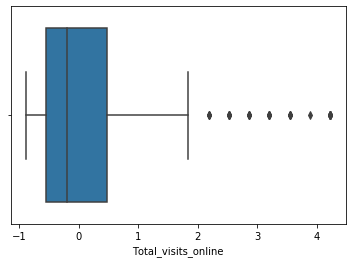

In [34]:
sns.boxplot(transformedData["Total_visits_online"])

Outliers still exist on the "Total_visits_online". We will leave these outliers as they currently are. I will reconsider this decision if this column appear to have great significance to the clustering achieved.

In [35]:
transformedData.describe()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,6.600000e+02,6.600000e+02,6.600000e+02,6.600000e+02,6.600000e+02
mean,-5.678959e-16,-4.006223e-15,1.157323e-16,1.944572e-16,-7.112156e-16
std,1.000758e+00,1.000758e+00,1.000758e+00,1.000758e+00,1.000758e+00
min,-2.138856e+00,-1.710864e+00,-1.473731e+00,-8.883795e-01,-1.251537e+00
25%,-8.446594e-01,-7.875852e-01,-8.604506e-01,-5.474897e-01,-9.022711e-01
50%,-2.128250e-01,1.356941e-01,-2.471705e-01,-2.065999e-01,-2.037386e-01
75%,8.415059e-01,5.973337e-01,9.793898e-01,4.751797e-01,4.947938e-01
max,2.375568e+00,2.443892e+00,1.592670e+00,4.224968e+00,2.241125e+00


In [36]:
transformedData.skew()

Avg_Credit_Limit       0.393753
Total_Credit_Cards     0.144879
Total_visits_bank      0.141896
Total_visits_online    2.225607
Total_calls_made       0.658905
dtype: float64

All data columns have A mean near zero and std deviation near 1. All columns bar "Total_online_visits" have acceptable skew.

# K-Means clustering

Will use ParametersGrid to try different values.

In [37]:
parameters = {'n_clusters' : [2,3,4,5,6,7,8,9,10] }

parameter_grid = ParameterGrid(parameters)

In [38]:
cluster_errors = []

model = KMeans(random_state=88)

for row in parameter_grid:
    model.set_params(**row)
    model.fit(transformedData)
    
    cluster_errors.append(model.inertia_)

clusterResults = pd.DataFrame({"num_clusters": [2,3,4,5,6,7,8,9,10]  , "cluster_errors": cluster_errors})
clusterResults[0:15]




,num_clusters,cluster_errors
0,2,1980.654971
1,3,1090.350994
2,4,860.748318
3,5,775.870940
4,6,697.721176
5,7,634.212081
6,8,598.588511
7,9,569.729371
8,10,545.571286


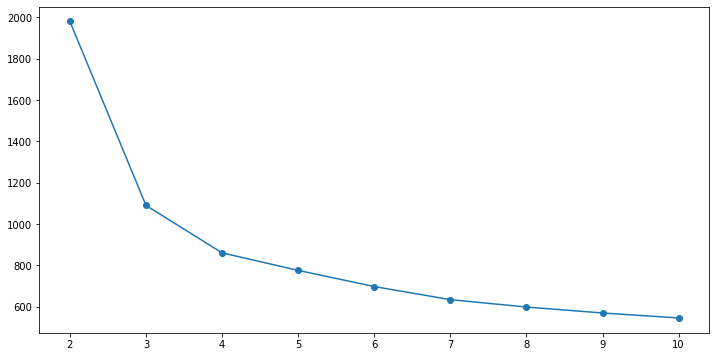

In [39]:
plt.figure(figsize=(12,6))
plt.plot( clusterResults.num_clusters, clusterResults.cluster_errors, marker = "o" )

The univarite analysis and multivariate analysis had suggested 3 or 4 was the most likely outcome.

Possible choices for the elbow point are 3 or 4.

Both anlayses agree.

I will choose 4 clusters. If the difference between two clusters are minimal we can run again with 3 clusters

In [40]:
kmeans = KMeans(n_clusters=4,  random_state=88)
kmeans.fit(transformedData)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=88, tol=0.0001, verbose=0)

### The silhoutette score

In [41]:
ss = silhouette_score(transformedData, model.labels_)
ss

0.22086186055571255

The silhoutette score K-Means clustering with four clusters is 0.22. This figure is disappointing. It may reflect the skewedness of total_visits_online column.

How many customers in each cluster?

In [42]:
labels = kmeans.labels_
counts = np.bincount(labels)#[labels>=0])
print(counts)

[219 168  50 223]


### What are the values of our centroids? 

In [43]:
centroids = kmeans.cluster_centers_
centroid_df = pd.DataFrame(centroids, columns = list(transformedData) )

In [44]:
centroid_df.transpose()

,0,1,2,3
Avg_Credit_Limit,0.838906,-0.714454,1.966490,-0.726532
Total_Credit_Cards,0.388647,0.350027,1.862226,-1.062913
Total_visits_bank,0.612542,0.731157,-1.105763,-0.904453
Total_visits_online,-0.558386,-0.545461,2.827319,0.325372
Total_calls_made,-0.533867,-0.573795,-0.874330,1.152605


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F501961DC8>,
      dtype=object)

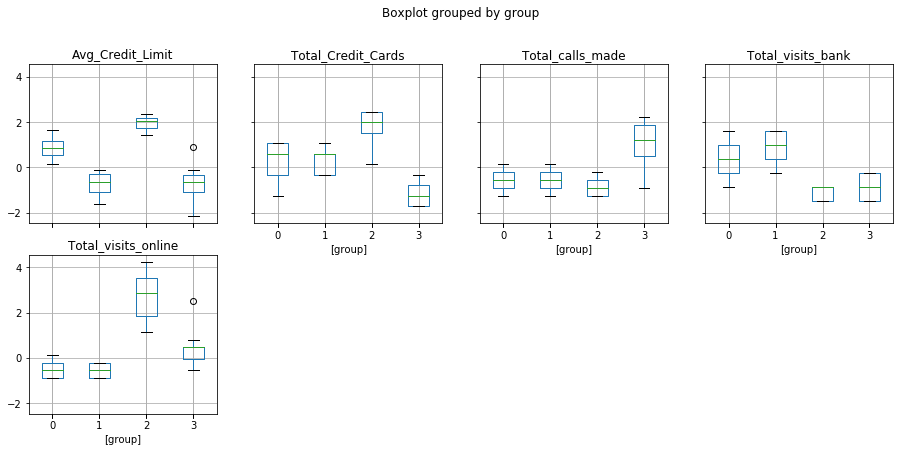

In [45]:
transformedData["group"] = kmeans.predict(transformedData) #predictions
transformedData.boxplot(by = 'group',  layout=(3,4), figsize=(15, 10))

## Result of K-Means Clustering

K-Means has resulted in the creation of 4 clusters. These are as follows:

Cluster Zero ("The moderate spenders") These customers have the above average credit card limits and have the second most number of credit cards. They are more likely to vist the bank rather than call or go online

Cluster 1 ("The cautious spenders") These customer have an average number of credit cards but considerably lower credit limits than the "moderate spenders". The like visting the bank and are less likely to go online or make a call.

Cluster 2 ("The Big Spenders") These customers have the highest credit card limits and the most number of credit cards. They make the most online vists. They are the least likely to make calls or visits to the bank.

Cluster 3 ("The visiting cautious") These customers have the least number of credit cards and the lowest credit card limits. They have a strong preference of calling the bank. They prefer online rather than visting the branch.

# Hierarchical Clustering with Silhouette score

In [46]:
parametersOne = {
                'n_clusters' : [2,3,4,5,6,7,8,9,10],
                 'affinity' : ["euclidean", "l1", "l2", "manhattan"],
                'linkage' : {"complete", "average", "single"}
             }

# ward linkage can only use euclidean distances
parametersTwo = {
                'n_clusters' : [2,3,4,5,6,7,8,9,10],
                 'affinity' : ["euclidean"],
                'linkage' : {"ward"}
             }

In [47]:
parameter_grid_One = ParameterGrid(parametersOne)
parameter_grid_Two = ParameterGrid(parametersTwo)
#list(parameter_grid)

In [48]:
allGrids = [parameter_grid_One,parameter_grid_Two]
#allGrids

In [50]:
bestscore = -1
bestgrid ="";
model = AgglomerativeClustering()

In [51]:
for grid in allGrids:
    for entry in grid:
        model.set_params(**entry)
        model.fit(transformedData)

        ss = silhouette_score(transformedData, model.labels_)
        #print(entry)
        if (ss > bestscore):
            bestscore = ss
            bestgrid = entry

print("parameter", bestgrid, "silhoutete score", bestscore)
    

parameter {'affinity': 'euclidean', 'linkage': 'complete', 'n_clusters': 3} silhoutete score 0.5778331778038417


The best model has a silhouette score of 0.577. It has the parameters 'affinity': 'euclidean', 'linkage': 'complete', 'n_clusters': 3

We will now run this model and comment upon the clusters it creates.

In [52]:
bestfitModel = AgglomerativeClustering(affinity = 'euclidean', linkage= 'complete', n_clusters= 3)
bestfitModel.fit(transformedData)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='complete', memory=None, n_clusters=3)

In [53]:
transformedData["group"] = bestfitModel.labels_
transformedData

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,group
0,1.630478,-1.249225,-0.860451,-0.547490,-1.251537,0
1,0.885387,-0.787585,-1.473731,2.520519,1.891859,2
2,0.885387,1.058973,-0.860451,0.134290,0.145528,0
3,0.336281,0.135694,-0.860451,-0.547490,0.145528,0
4,1.630478,0.597334,-1.473731,3.202298,-0.203739,1
...,...,...,...,...,...,...
655,1.619674,2.443892,-0.860451,2.520519,-1.251537,1
656,1.443058,2.443892,-0.860451,3.543188,-0.553005,1
657,2.029885,1.520613,-0.860451,2.179629,-0.902271,1
658,2.213443,2.443892,-0.860451,4.224968,-1.251537,1


In [54]:
groupedAgglomerative = transformedData.groupby("group")
display(groupedAgglomerative.count().T)
display(groupedAgglomerative.mean().T)

group,0,1,2
Avg_Credit_Limit,387,50,223
Total_Credit_Cards,387,50,223
Total_visits_bank,387,50,223
Total_visits_online,387,50,223
Total_calls_made,387,50,223


group,0,1,2
Avg_Credit_Limit,0.164579,1.966490,-0.726532
Total_Credit_Cards,0.371882,1.862226,-1.062913
Total_visits_bank,0.664034,-1.105763,-0.904453
Total_visits_online,-0.552775,2.827319,0.325372
Total_calls_made,-0.551200,-0.874330,1.152605


### Result of Agglomerative Clustering

The 3 groups created by agglomerative clustering can be described as thus:

#### Group 0 ("The moderates")
This group has 387 of the customers in it.

This group is the middle ground , they do take credit and they do have credit cards. They are most likely to visit the bank. They are equally as likely to use online or make a call.

#### Group 1 ("The Big Spenders")
This group has 50 customers in it.
These customer have large credit limits and large number of credit cards. They have a very strong perference for useing online services. They are the least likely to call.

#### Group 2 ("The Cautious")
This Group has 223 customers in it
These customers have small credit limits and the least number of credit cards. They are the most likely to call and appear averse to using online communications

# Dendrogram Production

A dendrogram produces a visualisation of the grouping. In order to produce this grouping we need the linkages matrix to be produced first.

In [55]:
transformedData.drop("group", axis=1, inplace=True)
transformedData

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.630478,-1.249225,-0.860451,-0.547490,-1.251537
1,0.885387,-0.787585,-1.473731,2.520519,1.891859
2,0.885387,1.058973,-0.860451,0.134290,0.145528
3,0.336281,0.135694,-0.860451,-0.547490,0.145528
4,1.630478,0.597334,-1.473731,3.202298,-0.203739
...,...,...,...,...,...
655,1.619674,2.443892,-0.860451,2.520519,-1.251537
656,1.443058,2.443892,-0.860451,3.543188,-0.553005
657,2.029885,1.520613,-0.860451,2.179629,-0.902271
658,2.213443,2.443892,-0.860451,4.224968,-1.251537


Earlier we established that the Agglomerative Algorthim with the the best silhouette score was done with the parameters "complete" and "euclidean". Do the same again

In [56]:
distances = linkage(transformedData, method='complete', metric='euclidean')
distances.shape

(659, 4)

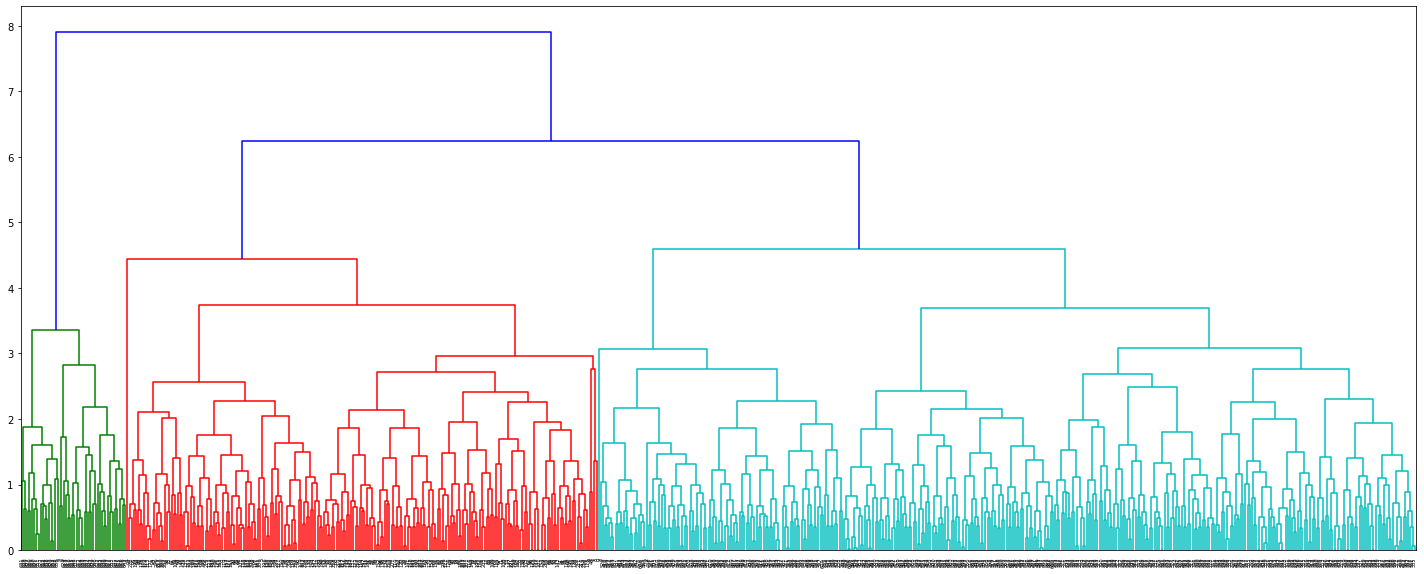

In [57]:
plt.figure(figsize=(25, 10))
dendrogram(distances)
plt.show()

What a beautiful but useless picture. Let us focus on the the section we are interested in.

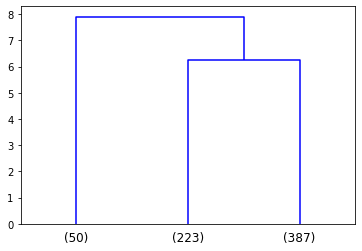

In [58]:
dendrogram(distances, truncate_mode='lastp', p=3)
plt.show()

The data has been split into 3 groups. They contain 50, 223 and 387 customer respectively. This is the same result that was achieved with Agglomerative Clustering

## Differences between K-Means and Hierarchical clustering

K-Means clustering resulted in 4 clusters and Agglomerative Clustering resulted in 3 clusters.

Both groups methods had 2 groups that could be described as "the big spenders" and "the cautious". The only significant difference was that the "middle" group was split into two.

The Agglomerative Clustering gave the best silhouette scores and is recommended of implementation

## The Key Questions


## How many clusters are there?

The silhouette score is a measure of how well the clustering reflects the original data. In this case the best silhouette score of 0.577 was achieved with 3 clusters using Agglomerative Clustering with the parameters affinity= euclidean and linkage = complete.

## How are these Segments different from each other

The clusters can be summarised as:

Group 0 ("The moderates")
This group has 387 of the customers in it.

This group is the middle ground , they do take credit and they do have credit cards. They are most likely to visit the bank. They are equally as likely to use online or make a call.

Group 1 ("The Big Spenders")
This group has 50 customers in it. These customer have large credit limits and large number of credit cards. They have a very strong perference for useing online services. They are the least likely to call.

Group 2 ("The Cautious")
This Group has 223 customers in it These customers have small credit limits and the least number of credit cards. They are the most likely to call and appear averse to using online communications


## Recommendations for the bank

"The Big Spenders" have a strong perefence for online services. These are ideal candidates for online marketing.

Instead of trying to sell "the moderates" credit cards and higher credit limits, consider the possibility of targeting "The moderates" to use online services more often. It may be that case that managing a credit card online makes it easier for customer to increase credit limits. 

Is it possible that having to ask another person for "credit" carries the risk of rejection and result in people being less willing ask. If this is true increasing internet use the key to having people get more credit cards and higher limits.

This idea is more credible when we look at "The Cautious". They have the least number of credit cards and lowest credit limits and they are the least likely to use "online" banking methods.